In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

from darkmod.utils import crop


In [2]:
import matplotlib

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams.update(
    {"text.usetex": False, "font.family": "serif", "font.serif": "Times New Roman"}
)

fontsize = 32  # General font size for all text
ticksize = 32  # tick size
plt.rcParams["font.size"] = fontsize
plt.rcParams["xtick.labelsize"] = ticksize
plt.rcParams["ytick.labelsize"] = ticksize


In [3]:
def load_peak_table(savedir, zis, reflections):
    """
    Load the peak table from a series of npz files.

    The output data table holds data from multiple simulations
    with both ground truth and reconstructed data.

    The filepath names are assumed to follow the patterns:
    reflection_1_zi_m1.npz, reflection_1_zi_1.npz ... etc
    (where m1 stands for zi=-1)

    Args:
        savedir (str): Directory where the data is saved
        zis (list): List of z values (e.g. [-1, 0, 1])
        reflections (list): List of reflections (e.g. [1, 2, 3, 4])

    Returns:
        data (np.array): Array of npz files of shape (4, 3).
            each data instance is a dictionary with keys.
    """
    data = np.empty((4, 3), dtype=object)
    for reflection in reflections:
        for zi in zis:
            if zi < 0:
                ss = "_zi_m" + str(np.abs(zi))
            else:
                ss = "_zi_" + str(zi)
            fname = "reflection_" + str(reflection) + ss
            file = os.path.join(savedir, fname + ".npz")
            data[reflection - 1, zi + 1] = np.load(file)
    return data


def load_scan(data, zi, reflection):
    """Load the strain-mosa scan from the data array.

    Args:
        data (npz dictionary): Data array instance from the npz file.
        zi (int): Index of the z value in the data array.
        reflection (int): Index of the reflection in the data array.

    Returns:
        scan (np.array): Strain-mosa scan of shape (m, n, o, p, q).
            first two dimensions are the pixel dimensions, and the last
            three dimensions are the strain-mosa dimensions (th, phi, chi).
    """
    d = data[reflection - 1, zi + 1]
    scan = np.zeros(d["strain_mosa_shape"], dtype=np.uint32).flatten()
    scan[d["sparse_indices"]] = d["strain_mosa_sparse"]
    scan = scan.reshape(d["strain_mosa_shape"])
    return scan


def show_sample_frame(data, zi, reflection):
    """Plot the central (angular) frame of the strain-mosa scan."""
    scan = load_scan(data, zi, reflection)
    m, n, o, p, q = scan.shape

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    _s = scan[:, :, o // 2, p // 2, q // 2].astype(np.float32)
    mask = data[reflection - 1, zi + 1]["intensity_mask"]
    im = ax.imshow(crop(_s, mask), cmap="plasma", vmin=44000, vmax=54000)
    fig.colorbar(im, ax=ax, fraction=0.0235, pad=0.04)
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.title(
        "Reflection " + str(reflection) + " at zi = " + str(zi) + "   [arb. units]"
    )
    plt.xlabel("Pixel column")
    plt.ylabel("Pixel row")
    plt.tight_layout()
    plt.show()


In [20]:
data[0, 1]['voxel_size']

array(0.03787879)

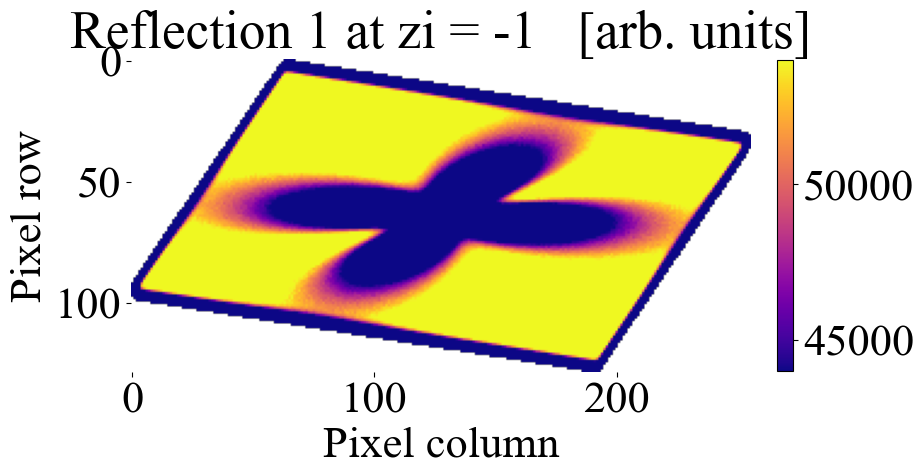

In [4]:
# Path to the directory in which reflections are stored
savedir = "/home/naxhe/workspace/darkmod/tests/end_to_end/defrec/saves/paper_1_run_3"
zis = [-1, 0, 1]
reflections = [1, 2, 3, 4]
# reflections = [2]
data = load_peak_table(savedir, zis, reflections)
show_sample_frame(data, zi=zis[0], reflection=reflections[0])

In [5]:
data

array([[NpzFile '/home/naxhe/workspace/darkmod/tests/end_to_end/defrec/saves/paper_1_run_3/reflection_1_zi_m1.npz' with keys: Q_rec, Q_true, strain_mosa_sparse, strain_mosa_shape, sparse_indices...,
        NpzFile '/home/naxhe/workspace/darkmod/tests/end_to_end/defrec/saves/paper_1_run_3/reflection_1_zi_0.npz' with keys: Q_rec, Q_true, strain_mosa_sparse, strain_mosa_shape, sparse_indices...,
        NpzFile '/home/naxhe/workspace/darkmod/tests/end_to_end/defrec/saves/paper_1_run_3/reflection_1_zi_1.npz' with keys: Q_rec, Q_true, strain_mosa_sparse, strain_mosa_shape, sparse_indices...],
       [NpzFile '/home/naxhe/workspace/darkmod/tests/end_to_end/defrec/saves/paper_1_run_3/reflection_2_zi_m1.npz' with keys: Q_rec, Q_true, strain_mosa_sparse, strain_mosa_shape, sparse_indices...,
        NpzFile '/home/naxhe/workspace/darkmod/tests/end_to_end/defrec/saves/paper_1_run_3/reflection_2_zi_0.npz' with keys: Q_rec, Q_true, strain_mosa_sparse, strain_mosa_shape, sparse_indices...,
       

In [6]:
scan = load_scan(data, zi=0, reflection=1)
m, n, o, p, q = scan.shape

In [ ]:
scan

In [6]:
def add_noise(image, mu=99.453, std=2.317):
    """Thermal + Shot noise model for detector counting errors.

    Args:
        size (:obj:`np.ndarray`): Stack of images.
        mu (:obj:`float`): Mean thermal noise.
        std (:obj:`float`): Standard devation of thermal noise.

    Returns:
        :obj:`numpy array`: Noise array of shape=size.
    """
    noisy_image = np.random.poisson(lam=image).astype(float)  # shot noise
    noisy_image += np.random.normal(mu, std, size=image.shape)  # thermal noise
    return noisy_image

In [30]:
import darling

In [40]:
(
    scan.astype(np.uint16).shape[2:],
    data[0, 1]["delta_theta"].shape,
    data[0, 1]["phi"].shape,
    data[0, 1]["chi"].shape,
)

((11, 41, 41), (11,), (41,), (41,))

In [92]:
scanuint16 = scan.astype(np.uint16)
coordinates = (data[0, 1]["delta_theta"], data[0, 1]["phi"], data[0, 1]["chi"])


In [ ]:
# Run the reconstructor to get back the deformation gradient tensor field
defgrads = []
betas = []
betas_true = []

from importlib import reload

import darkmod.reconstruct

reload(darkmod.reconstruct)

zcenter = data[zis[len(zis) // 2], reflections[0]]["Q_sample_3D_true"].shape[2] // 2

for zi in zis:
    zindex = zi + 1
    bp_slice_ind = zcenter - zi

    diffraction_vectors_rec = [
        reflection[zindex]["bp_Q_sample_3D_rec"] for reflection in data
    ]
    hkl = [reflection[zindex]["hkl"] for reflection in data]
    UB_reference = data[0, zindex]["U_0"] @ data[0, zindex]["B_0"]
    print(UB_reference.shape)
    defgrad = darkmod.reconstruct.deformation(
        [d[:, :, bp_slice_ind, :] for d in diffraction_vectors_rec],
        hkl,
        UB_reference,
    )

    defgrads.append(defgrad.copy())

    mask = ~(np.sum(defgrad, axis=(-1, -2)) == 0)
    beta = defgrad.copy()

    beta_true_3D = data[0, zindex]["defgrad"]
    for i in range(3):
        beta[..., i, i] -= 1
        beta_true_3D[..., i, i] -= 1

    betas.append(beta.copy())
    betas_true.append(beta_true_3D[:, :, bp_slice_ind, :, :].copy())

(3, 3)
(3, 3)
(3, 3)


In [ ]:
zcenter = data[zis[len(zis) // 2], reflections[0]]["Q_sample_3D_true"].shape[2] // 2
zi = 1
zindex = zi + 1
bp_slice_ind = zcenter - zi
print(bp_slice_ind)

Hmatrix = np.array([data[i, zindex]["hkl"] for i in range(4)]).T
UB_reference = data[0, zindex]["U_0"] @ data[0, zindex]["B_0"] 
y_s_0 = UB_reference @ Hmatrix
F = data[0, zindex]["defgrad"][
    50,
    100,
    bp_slice_ind
]

y_s = np.array([data[i, zindex]["bp_Q_sample_3D_rec"][50, 100, bp_slice_ind] for i in range(4)]).T
np.linalg.inv(np.linalg.inv(y_s_0 @ y_s_0.T) @ y_s_0 @ y_s.T) , F

12


(array([[ 1.00000888e+00, -1.56343133e-05,  3.14993718e-06],
        [ 2.28561979e-06,  1.00000218e+00, -1.92065502e-06],
        [-5.55073547e-06,  6.79923103e-06,  9.99999659e-01]]),
 array([[ 1.00000898e+00, -1.54653539e-05,  3.24363002e-06],
        [ 2.35359016e-06,  1.00000167e+00, -2.01391256e-06],
        [-5.66584199e-06,  6.89555946e-06,  9.99999385e-01]]))

In [165]:
data[i, 1]["Q_rec"].shape

(272, 272, 3)

In [132]:
list(data[0, 1].keys())


Hmatrix = np.array([data[i, 1]["hkl"] for i in range(4)]).T
G_0 = UB_reference @ Hmatrix

F_sample = np.zeros((m, n, 3, 3))
for i in range(m):
    for j in range(n):
        if mask[i, j]:
            F_sample[i, j] = np.linalg.inv(
                np.linalg.lstsq(G_0.T, Q[i, j, ...].T, rcond=None)[0]
            )
return F_sample

Q_0 = np.zeros((4, 3))
for i in range(4):
    U_0 = data[i, 1]["U_0"]
    B_0 = data[i, 1]["B_0"]
    hkl = data[i, 1]["hkl"]
    Q_0[i] = U_0 @ B_0 @ hkl
Q_0


array([[-1.55167197, -1.55167197,  4.65501591],
       [-1.55167197,  1.55167197,  4.65501591],
       [ 1.55167197,  1.55167197,  4.65501591],
       [ 1.55167197, -1.55167197,  4.65501591]])

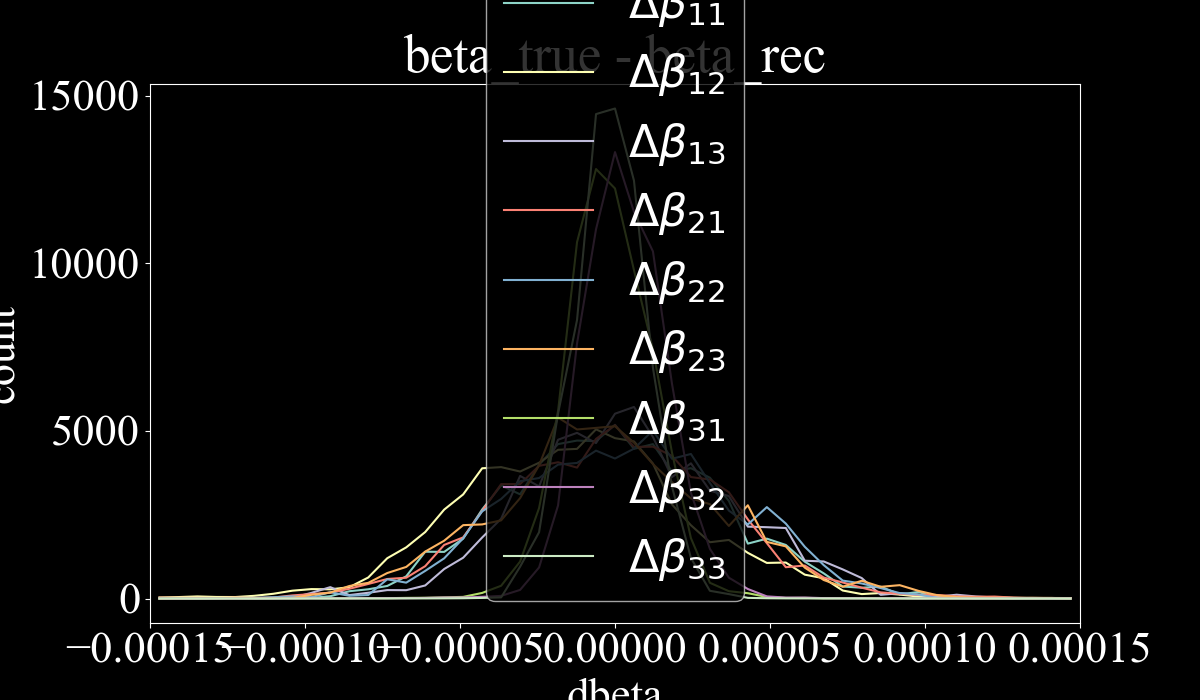

In [ ]:
dbeta = beta[0] - betas_true[0]
bins = np.linspace(-0.00015, 0.00015, 50)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
for i in range(3):
    for j in range(3):
        h, b = np.histogram(dbeta[..., i, j].flatten(), bins=bins)
        bc = (b[:-1] + b[1:]) / 2
        ax.plot(bc, h, label=f"$\Delta \\beta_{{{i + 1}{j + 1}}}$")
ax.set_title("beta_true - beta_rec")
ax.legend()
ax.set_xlim(-0.00015, 0.00015)
ax.set_xlabel("dbeta")
ax.set_ylabel("count")
plt.show()

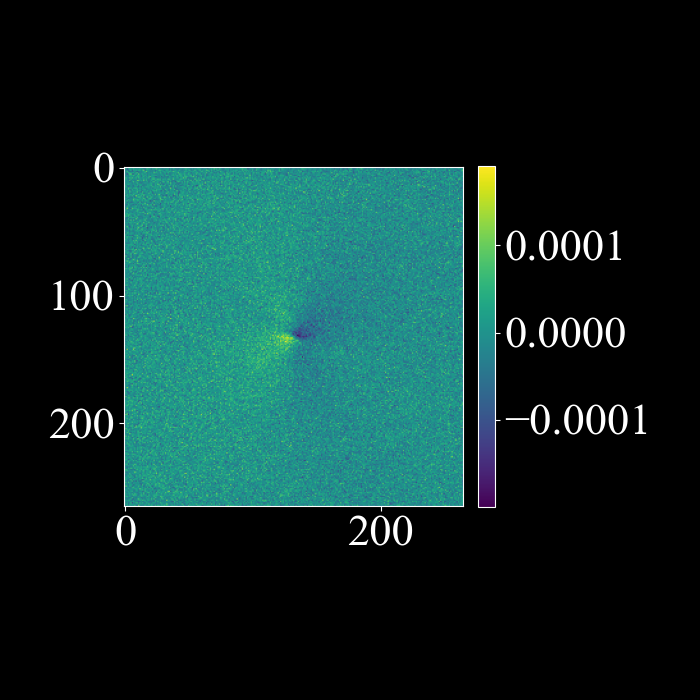

In [106]:
plt.style.use("dark_background")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
im = ax.imshow(betas[1][..., 0, 0])
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [61]:
coordinates = np.meshgrid(
    data[0, 1]["delta_theta"], data[0, 1]["phi"], data[0, 1]["chi"], indexing="ij"
)
scanuint16 = scan.astype(np.uint16)

In [78]:
%matplotlib ipympl

In [91]:
from darkmod import reconstruct

reconstruct.deformation(
    data[0, 1]["Q_true"], data[0, 1]["hkl"], data[0, 1]["U_0"] @ data[0, 1]["B_0"]
)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [90]:
data[0, 1]["hkl"]

array([-1, -1,  3])

In [10]:
data[0, 1]['hkl'], data[0, 1]['U_0'], data[0, 1]['B_0']

(array([-1, -1,  3]),
 array([[ 1.00000000e+00, -6.02156939e-18,  1.06741601e-16],
        [-9.57823032e-18,  1.00000000e+00,  3.98146086e-16],
        [-1.56587512e-16, -3.51707906e-16,  1.00000000e+00]]),
 array([[ 1.55167197e+00, -9.50125056e-17, -9.50125056e-17],
        [ 0.00000000e+00,  1.55167197e+00, -9.50125056e-17],
        [ 0.00000000e+00,  0.00000000e+00,  1.55167197e+00]]))

In [12]:
data[0, 1]['hkl'], data[1, 1]['hkl'], data[2, 1]['hkl'], data[3, 1]['hkl']

(array([-1, -1,  3]),
 array([-1.,  1.,  3.]),
 array([1., 1., 3.]),
 array([ 1., -1.,  3.]))

In [ ]:
list(data[0, 1].keys())

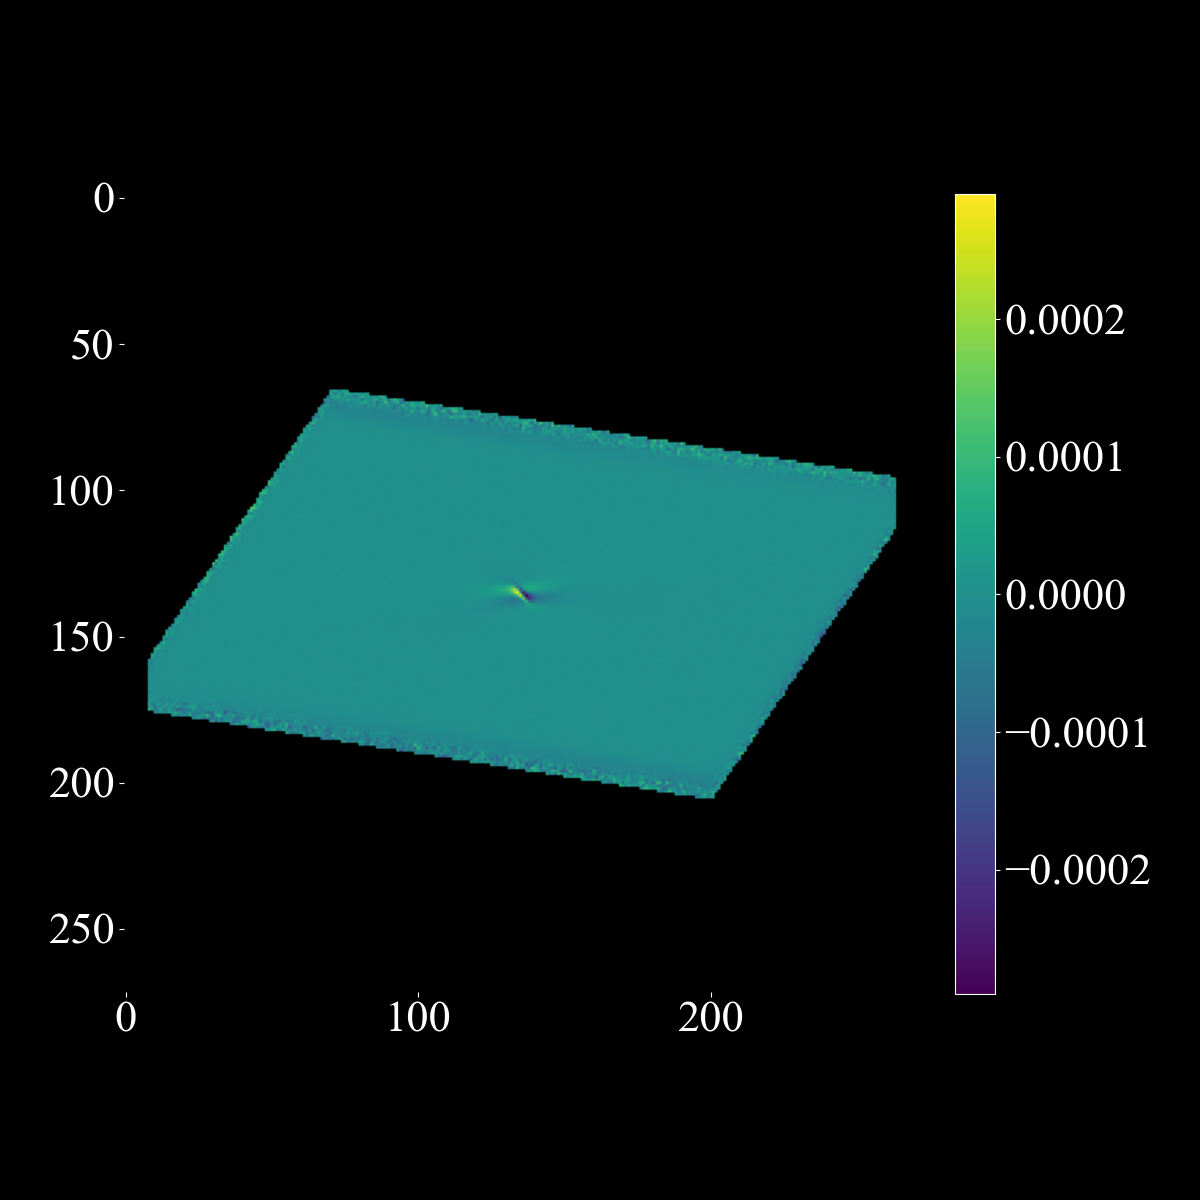

In [ ]:
dQ = data[0, 1]["Q_rec"] - data[0, 1]["Q_true"]
plt.style.use("dark_background")
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
im = ax.imshow(dQ[..., 0])
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()

In [63]:
mu, cov = darling.properties.moments(scanuint16, coordinates)

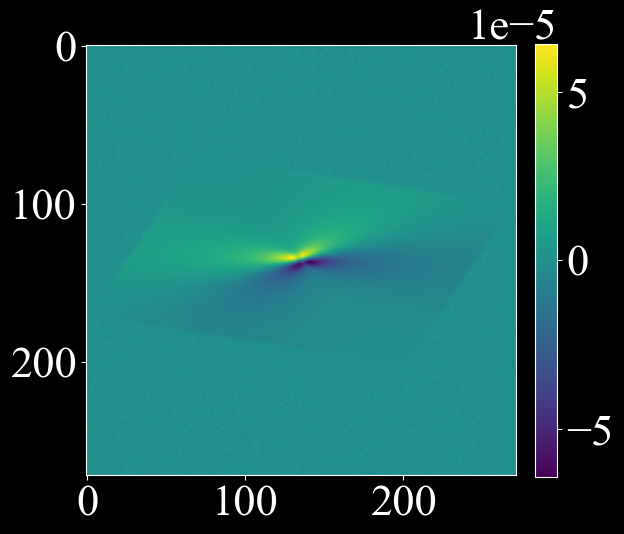

In [ ]:
plt.style.use("dark_background")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
im = ax.imshow(mu[..., 1])
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

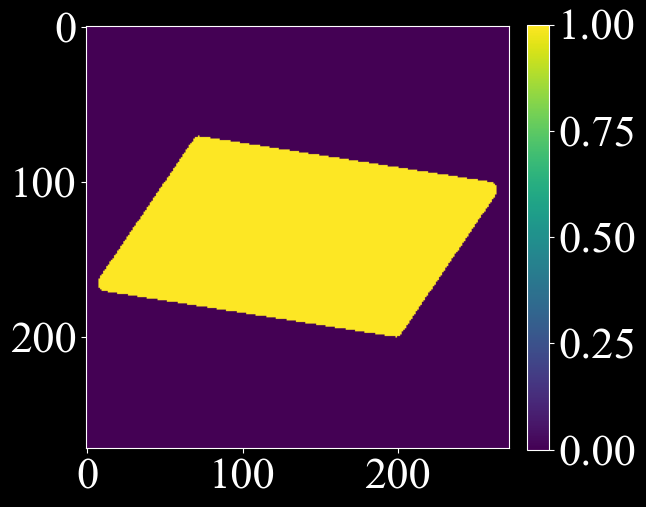

In [19]:
mask = data[0, 1]["intensity_mask"]

plt.style.use("dark_background")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
im = ax.imshow(mask)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

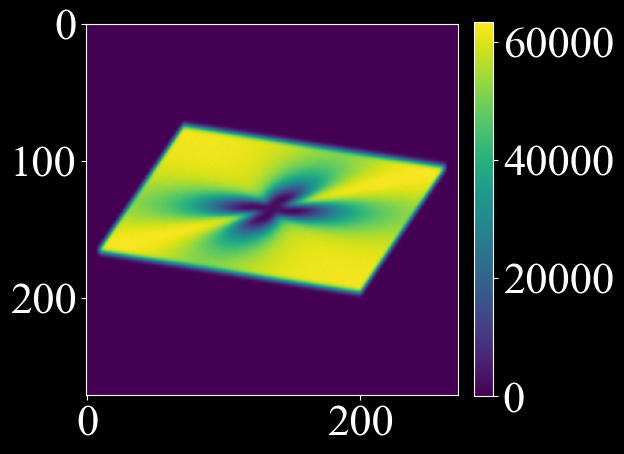

In [ ]:
plt.style.use("dark_background")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
im = ax.imshow(scan[..., 5, 20, 20])
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()